# Plotting Script for Plotting B/G color MEI bias 

In [1]:
%load_ext autoreload
%autoreload 2

import datajoint as dj

dj.config["display.limit"] = 50
dj.config["enable_python_native_blobs"] = True
dj.config['schema_name'] = "nnfabrik_color_mei"
schema = dj.schema("nnfabrik_color_mei")

from nnfabrik.main import *

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd

Connecting kwilleke@sinzlab.chlkmukhxp6i.eu-central-1.rds.amazonaws.com:3306


### Select a dataset hash

In [2]:
keys = [dict(dataset_hash='98d7845e60d7c68a6a4145b4ef85498c', seed=1000),
       dict(dataset_hash='4aa96af6f11a2d48463ed03ab6fee5dc', seed=1000)]

## Import Scoring Tables

In [3]:
from nndichromacy.tables.scores import TestCorrelationBlueTestSet, TestCorrelationGreenTestSet, TestCorrelationDependenthighMSE, TestCorrelation
from nndichromacy.tables.scores import CorrelationToAvergeEnsemble, CorrToAvgEnsembleBlueSet, CorrToAvgEnsembleDepSetHighMSE, CorrToAvgEnsembleGreenSet
from nndichromacy.tables.measures import OracleCorrelation, OracleCorrelationBlueSet, OracleCorrelationGreenSet, OracleCorrelationDepSet

# Populate Scoring Tables

In [ ]:
CorrelationToAvergeEnsemble.populate(keys, display_progress=True)
CorrToAvgEnsembleBlueSet.populate(keys, display_progress=True)
CorrToAvgEnsembleDepSetHighMSE.populate(keys, display_progress=True)
CorrToAvgEnsembleGreenSet.populate(keys, display_progress=True)

TestCorrelationBlueTestSet.populate(keys, display_progress=True)
TestCorrelationGreenTestSet.populate(keys, display_progress=True)
TestCorrelationDependenthighMSE.populate(keys, display_progress=True)
TestCorrelation.populate(keys, display_progress=True)

OracleCorrelation.populate(keys, display_progress=True)
OracleCorrelationBlueSet.populate(keys, display_progress=True)
OracleCorrelationGreenSet.populate(keys, display_progress=True)
OracleCorrelationDepSet.populate(keys, display_progress=True)

# Fetch the Scores and Measures

In [39]:
corr_overall, corr_dep, corr_g, corr_b, dataset_comment = (Dataset * TestCorrelation * TestCorrelationDependenthighMSE 
 * TestCorrelationGreenTestSet*TestCorrelationBlueTestSet & keys).fetch("test_correlation", "test_correlation_dependent", "test_correlation_green", "test_correlation_blue", "dataset_comment")
print(dataset_comment)

['24046-9-25 normalized' '23656-27-8 normalized']


In [40]:
avg_corr_overall, avg_corr_dep, avg_corr_g, avg_corr_b, dataset_comment = (Dataset * CorrelationToAvergeEnsemble * CorrToAvgEnsembleDepSetHighMSE 
 * CorrToAvgEnsembleGreenSet*CorrToAvgEnsembleBlueSet & keys).fetch("avg_correlation", "avg_test_correlation_dependent", "avg_test_correlation_green", "avg_test_correlation_blue", "dataset_comment")
print(dataset_comment)

['24046-9-25 normalized' '23656-27-8 normalized']


In [41]:
oracle_overall, oracle_dep, oracle_g, oracle_b, dataset_comment = (Dataset * OracleCorrelation * OracleCorrelationDepSet 
 * OracleCorrelationGreenSet*OracleCorrelationBlueSet & keys).fetch("oracle_correlation", "oracle_correlation_dependent", "oracle_correlation_green", "oracle_correlation_blue", "dataset_comment")
print(dataset_comment)

['24046-9-25 normalized' '23656-27-8 normalized']


# Create a Dataframe from Tables

In [42]:
oracles, avg_correlations, correlations, test_condition, datasets = [], [], [], [], []
for i, dataset in enumerate(dataset_comment):
    
    oracles.extend([oracle_overall[i], oracle_dep[i], oracle_g[i], oracle_b[i]])
    
    avg_correlations.extend([avg_corr_overall[i], avg_corr_dep[i], avg_corr_g[i], avg_corr_b[i]])
    
    correlations.extend([corr_overall[i], corr_dep[i], corr_g[i], corr_b[i]])
    
    test_condition.extend(["Full", "Dependent", "G", "B"])
    datasets.extend([dataset]*4)
    
df = pd.DataFrame({'fraction oracle': avg_correlations,
                   'oracle correlation': oracles,
                   'test correlation': correlations,
                   'test condition': test_condition,
                   'dataset': datasets})

In [46]:
df

,fraction oracle,oracle correlation,test correlation,test condition,dataset
0,0.473407,0.460967,0.229477,Full,24046-9-25 normalized
1,0.428979,0.449065,0.229924,Dependent,24046-9-25 normalized
2,0.485861,0.451857,0.218911,G,24046-9-25 normalized
3,0.479867,0.455600,0.219891,B,24046-9-25 normalized
4,0.463191,0.464614,0.231394,Full,23656-27-8 normalized
5,0.427269,0.443302,0.232237,Dependent,23656-27-8 normalized
6,0.464708,0.436425,0.206075,G,23656-27-8 normalized
7,0.489963,0.471800,0.234198,B,23656-27-8 normalized


# Plot the results

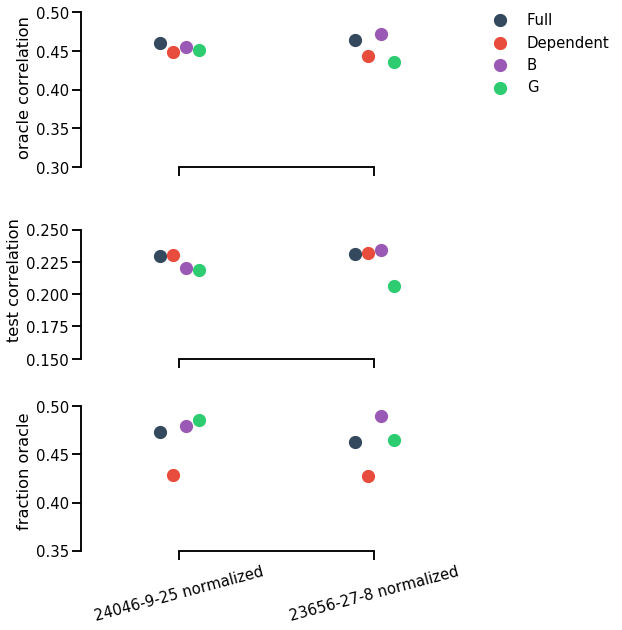

In [54]:

fig, axs = plt.subplots(3,1, sharex=True, figsize=(7,10))
sns.set_context('talk', font_scale=0.9)

my_hue_order = ['Full', 'Dependent', 'B', 'G']
flatui = ["#34495e",  "#e74c3c", "#9b59b6","#2ecc71"]


ax0=axs[0]
sns.pointplot(x="dataset", y="oracle correlation", hue="test condition",
                 data=df, join=False, hue_order=my_hue_order, palette=sns.color_palette(flatui),dodge=dodge, 
                 ax=ax0,);

ax1=axs[1]
sns.pointplot(x="dataset", y="test correlation", hue="test condition",
                 data=df, join=False, hue_order=my_hue_order, palette=sns.color_palette(flatui),dodge=dodge, 
                 ax=ax1,);

ax2=axs[2]
sns.pointplot(x="dataset", y="fraction oracle", hue="test condition",
                 data=df, join=False, hue_order=my_hue_order, palette=sns.color_palette(flatui),dodge=dodge, 
                 ax=ax2,);

ax1.get_legend().remove()
ax2.get_legend().remove()

ax0.set_yticks(np.linspace(.30,.50,5))
ax1.set_yticks(np.linspace(.15,.25,5))
ax2.set_yticks(np.linspace(.35,.50,4))

ax0.set_xlabel('')
ax1.set_xlabel('')
ax2.set_xlabel('')

ax2.set_xticklabels(list(ax2.get_xticklabels()), rotation=15, ha="center")
sns.despine(trim=True)
ax0.legend(bbox_to_anchor=(1, 1.05), loc=2, frameon=False)

plt.savefig('HighMSE_Session_Performance.png',dpi=100, bbox_inches='tight')